# Feature selection and feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.linalg as sp_la

## Data

Today we will keep working with the set of Craigslist listings for used cars.

All of this section is *exactly the same* as Wednesday and Friday.

First I make my converters.

In [2]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

Now we actually load the data.

In [3]:
# This dataset is the mazda subsample from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup

data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

Let's get some summary statistics and do a **pairplot** so we can see what's going on.

In [4]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))


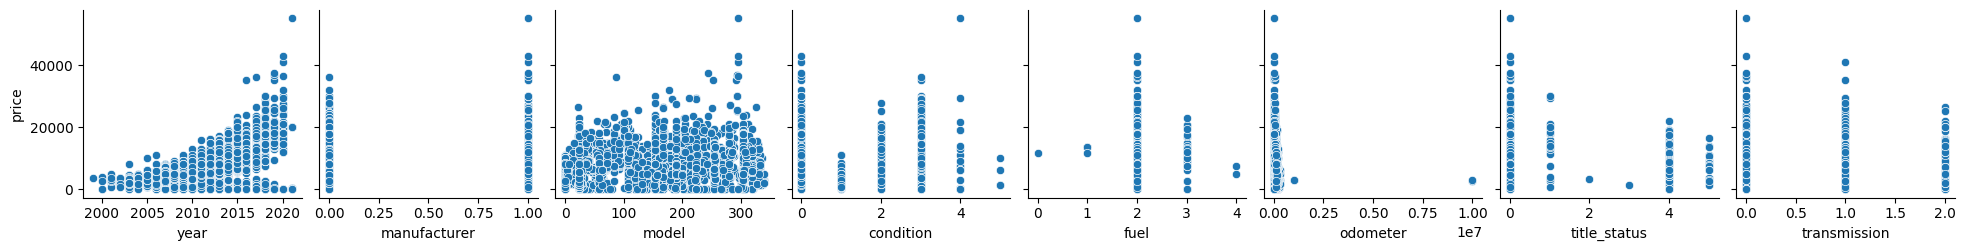

In [5]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

Let's calculate *correlations* between price and the other variables. (Remind me what correlation values vary between?)

In [6]:
for i in range(len(columns)):
    print(columns[i], np.corrcoef(data[:, 0], data[:, i], rowvar=True)[0,1])

price 1.0
year 0.5607406077976831
manufacturer 0.018020904958063123
model 0.12473024847425893
condition -0.01203518209383884
fuel 0.032451877318551946
odometer -0.1272187764664638
title_status 0.0023381200685889886
transmission -0.14757003596193927


# Which model is best?

## Stepwise regression

We can do **feature selection**. Here we do additive feature selection:
* repeatedly add an independent variable, train, and report $R^2$

We could also do a variant of additive feature selection using the correlations:
* sort independent variables by size of correlation (positive or negative!) with the dependent variable
* repeatedly add the independent variable with the next biggest correlation; if it leads to higher $R^2$, keep it; if it doesn't, drop it again

And we could also go from most features to fewest:
* start with a model fit using *all* independent variables
* repeatedly take an independent variable out; if the resulting model has higher $R^2$, leave that variable out going forward

There are many other options for feature selection!

In this code block, I calculate the *powerset* of all the independent variables. Then, for each subset of the independent variables I train a model and calculate MSSE (on the training data) and $R^2$ (on the test data). Then, I report the ten worst and ten best performing sets of independent variables by MSSE and by $R^2$.

Note:
* sometimes models with fewer variables work better than models with more
* sometimes a model may fit the training data better but the test data worse

### First, split our data

Let's split our data into **train** and **test**. Let's make sure and sort by time first, because we don't want to let the future predict the past.

In [10]:
data = data[data[:, 1].argsort()]
print(getSummaryStatistics(data))
print(getShapeType(data))

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))
(2526, 9) (632, 9)


In [ ]:
from itertools import chain, combinations

def powerset(variables):
    return chain.from_iterable(combinations(variables, r) for r in range(len(variables)+1))

def msse(y, yhat):
    r = (np.square(y - yhat)).mean()
    return r

res = {}
for variableset in powerset(range(1, train.shape[1])):
    # fit the multiple linear regression
    c = fit(train, variableset, 0)
    # calculate MSSE and R^2
    res[variableset] = (msse(train[:, 0], predict(train, variableset, c)), rsquared(test[:, 0], predict(test, variableset, c)))

In [ ]:
# sort by R^2
byrsquared = sorted(res.items(), key=lambda item: item[1][1])
print("Worst R^2")
for i in range(10):
    print([columns[x] for x in byrsquared[i][0]], byrsquared[i][1])
print("Best R^2")
for i in range(1, 11):
    print([columns[x] for x in byrsquared[-i][0]], byrsquared[-i][1])

In [ ]:
# sort by MSSE
bymsse = sorted(res.items(), key=lambda item: item[1][0])
print("Worst MSSE")
for i in range(1, 11):
    print([columns[x] for x in bymsse[-i][0]], bymsse[-i][1])
print("Best MSSE")
for i in range(10):
    print([columns[x] for x in bymsse[i][0]], bymsse[i][1])


# Feature engineering

When we fiddle with our independent variables to make the models better, we call this **feature engineering**. For example, adding the square of age.

So we have two ways to experiment with a single modeling approach:
* feature selection
* feature engineering

I would not call data transformations (like max-min normalization) feature engineering, since you should do them before you start modeling, but you might choose to consider them feature engineering.

In real-world projects, you can spend a huge amount of time doing feature selection and feature engineering. It can get overwhelming quickly! Keep good track of your work through either an experiment logbook, or experiment tracking software like [weights and biases](https://wandb.ai/site).

## Underfitting and overfitting